In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy.random as npr
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [2]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1 / self.p / max(1, self.p, self.q)
                self.p1 = 1/  max(1, self.p, self.q)
                self.p2 = 1 / self.q / max(1, self.p, self.q)
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                    neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                    weights = self.g[i, neighbors]  # Get corresponding edge weights
    
                    # Sort neighbors and weights by weight
                    sorted_neighbors_weights = sorted(zip(neighbors, weights), key=lambda x: x[0])
                    sorted_neighbors, sorted_weights = zip(*sorted_neighbors_weights)

                    self.adj_list.append(list(zip(sorted_neighbors, sorted_weights / np.sum(sorted_weights))))
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """
                # Sample a neighbour with probability proportional
                # to the edge weight from vertex --> neighbour
                neighbours, weights = zip(*self.adj_list[vertex])
                
                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return np.random.choice(neighbours, p=weights)
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()
                        
                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        elif self.g[walk[-2]][new_node]:
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """          
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=self.epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

In [3]:
def plot_graph ( G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

## Showing DeepWalk

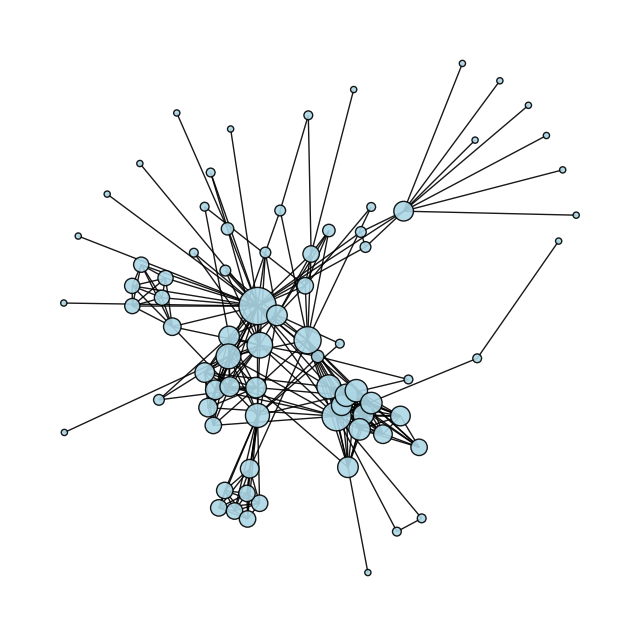

In [4]:
G = nx.les_miserables_graph()
# draw a graph with light blue nodes outlined with black and grey edges (without labels)
plot_graph(G, "lightblue")

adjmat = nx.adjacency_matrix(G).todense()

In [5]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

In [6]:
n2v.train(30, 0.05)

INFO - 2023-11-06 10:45:39,667: collecting all words and their counts
INFO - 2023-11-06 10:45:39,669: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-06 10:45:39,686: collected 77 word types from a corpus of 61600 raw words and 770 sentences
INFO - 2023-11-06 10:45:39,688: Creating a fresh vocabulary
INFO - 2023-11-06 10:45:39,690: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-11-06T10:45:39.690318', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-06 10:45:39,692: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 61600 word corpus (100.00% of original 61600, drops 0)', 'datetime': '2023-11-06T10:45:39.692090', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platf

In [7]:
# n2v.plot_embeddings(2, gt)

In [8]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# from sknetwork.clustering import Louvain, get_modularity
# import scipy.sparse as sp
# from sknetwork.visualization import svg_graph, svg_bigraph

# louvain = Louvain()
# labels = louvain.fit_predict(adjmat)

In [9]:
# G = nx.karate_club_graph()
# nx.draw(G, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
# adjmat = nx.adjacency_matrix(G).todense()

In [10]:
# n2v.plot_embeddings(2, labels)

## Showing Homophily

INFO - 2023-11-06 10:45:43,597: collecting all words and their counts
INFO - 2023-11-06 10:45:43,598: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-06 10:45:43,613: collected 77 word types from a corpus of 61600 raw words and 770 sentences
INFO - 2023-11-06 10:45:43,614: Creating a fresh vocabulary
INFO - 2023-11-06 10:45:43,616: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-11-06T10:45:43.616846', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-06 10:45:43,618: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 61600 word corpus (100.00% of original 61600, drops 0)', 'datetime': '2023-11-06T10:45:43.618700', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platf

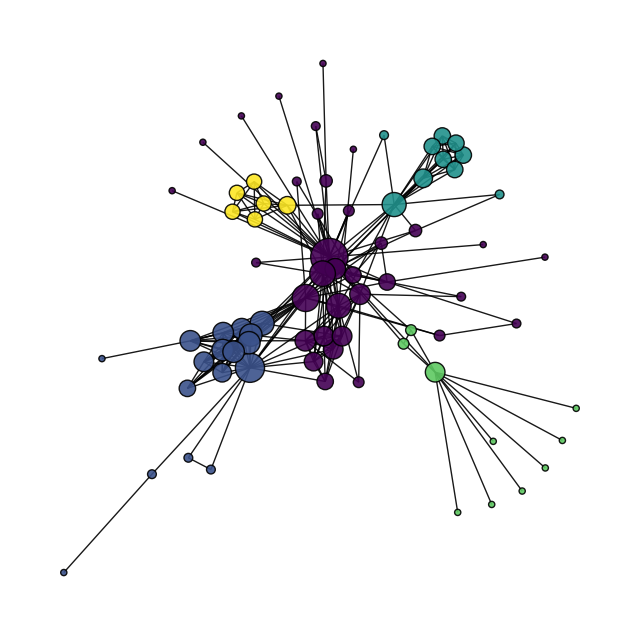

In [11]:
''' do k means clustering for different p and q values and assign 
colours to the nodes based on the cluster they belong to '''

# p = 1, q=0.5
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 0.5)
n2v.train(30, 0.05)
embeddings = np.array(n2v.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_

plot_graph(G, labels)


## Showing Structural Equivalence

INFO - 2023-11-06 10:45:45,543: collecting all words and their counts
INFO - 2023-11-06 10:45:45,544: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-06 10:45:45,546: collected 77 word types from a corpus of 2772 raw words and 924 sentences
INFO - 2023-11-06 10:45:45,548: Creating a fresh vocabulary
INFO - 2023-11-06 10:45:45,549: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-11-06T10:45:45.549738', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-06 10:45:45,551: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 2772 word corpus (100.00% of original 2772, drops 0)', 'datetime': '2023-11-06T10:45:45.550990', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform

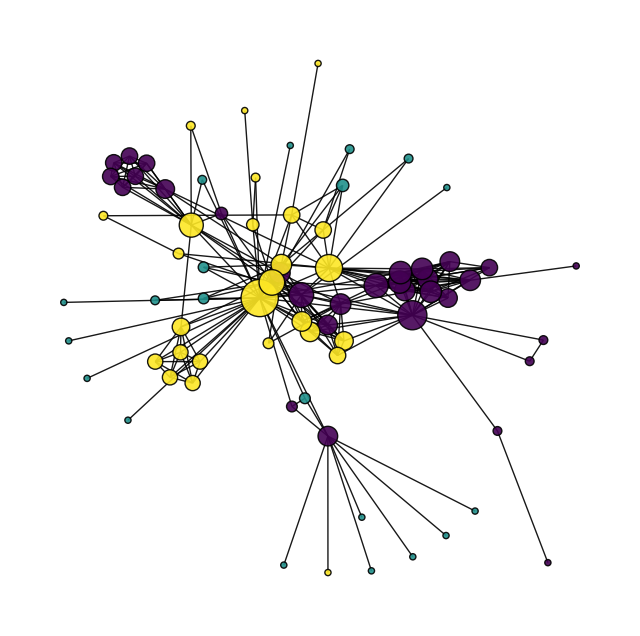

In [12]:
# p = 1, q=2

# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v_SE = Node2Vec(adjmat, 3, 16, 12, 3, 1, 2)
n2v_SE.train(30, 0.05)
embeddings = np.array(n2v_SE.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_
plot_graph(G, labels)

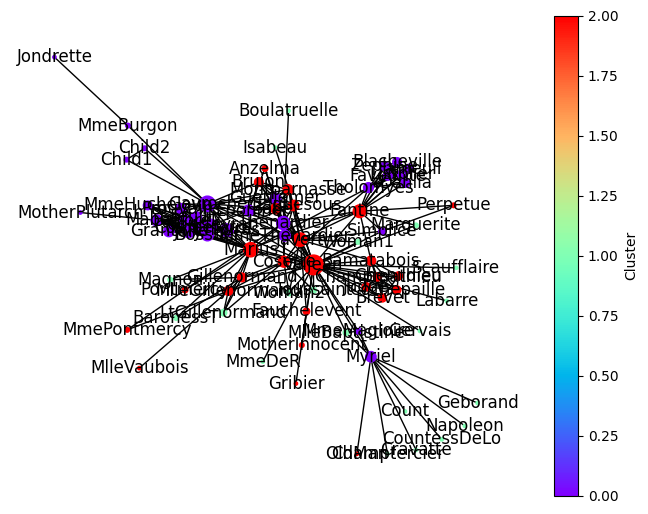

In [13]:
# Compute node degrees
node_degrees = dict(G.degree())

# Determine the maximum degree for scaling node sizes
max_degree = max(node_degrees.values())

# Define a scaling factor for node sizes
scale_factor = 200  # Adjust this as needed to control the node size

# Compute node sizes proportional to their degree
node_sizes = [scale_factor * node_degrees[node] / max_degree for node in G.nodes]

# Plot the graph with nodes sized by their degree
pos = nx.spring_layout(G)  # Use a layout algorithm that suits your needs
nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow, node_size=node_sizes)

# Add colorbar for node colors
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(labels), vmax=max(labels)))
sm.set_array([])
plt.colorbar(sm, label='Cluster')
plt.show()